# An Implementation of [Hiding Images in Plain Sight: Deep Steganography](https://proceedings.neurips.cc/paper_files/paper/2017/file/838e8afb1ca34354ac209f53d90c3a43-Paper.pdf)

A deep learning-based approach to image steganography, allowing a full-color image to be hidden within another image of the same size. The system consists of three neural networks trained together to encode and decode images efficiently.


## Overview

**Goal:** Hide a secret image inside a cover image while minimizing visible distortions.

Instead of embedding data in LSBs, the system should learn to encode the secret image across all pixel values.


## Architecture

### Preparation Network

- Converts the secret image into a more compressible form.
- Extracts useful features (e.g., edges, textures) to make hiding more efficient.
- Uses convolutional layers to encode the secret image before embedding.

### Hiding Network

- Takes the transformed secret image and the cover image as inputs.
- Uses multiple convolutional layers (5 layers, 50 filters each) to create a stego image.
- The stego image should look visually similar to the original cover image while embedding the secret image.

### Reveal Network

- Takes the stego image as input and reconstructs the secret image.
- Uses a convolutional decoder to extract the hidden content.

### Loss Function

$ L(c,c',s,s')=||c-c'||+β||s-s'| $

- c,c' are the original and stego images
- s, s' are the original and recovered secret images
- β is a weighting parameter controlling the trade-off between cover image distortion and secret image recovery

In [ ]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchmetrics
from torchmetrics.image.psnr import PeakSignalNoiseRatio
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
from torchinfo import summary

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
!nvidia-smi

Thu Feb 20 18:05:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Using CIFAR100 dataset and using BICUBIC Interpolation for resizing 32x32 -> 128x128 

In [ ]:
train_test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])

In [ ]:
# Define transform with Bicubic Interpolation (Best Quality)

train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=train_test_transform)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=train_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 169M/169M [00:04<00:00, 42.0MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [ ]:
sample, label = next(iter(train_loader))
print(sample.shape)
print(label.shape)
sample[0]

torch.Size([32, 3, 128, 128])
torch.Size([32])


tensor([[[0.1412, 0.1412, 0.1412,  ..., 0.1608, 0.1608, 0.1608],
         [0.1412, 0.1412, 0.1412,  ..., 0.1608, 0.1608, 0.1608],
         [0.1412, 0.1412, 0.1412,  ..., 0.1608, 0.1608, 0.1608],
         ...,
         [0.2196, 0.2235, 0.2392,  ..., 0.2627, 0.2627, 0.2627],
         [0.2314, 0.2353, 0.2510,  ..., 0.2627, 0.2627, 0.2627],
         [0.2353, 0.2392, 0.2549,  ..., 0.2627, 0.2627, 0.2627]],

        [[0.2510, 0.2549, 0.2549,  ..., 0.2196, 0.2196, 0.2196],
         [0.2510, 0.2549, 0.2549,  ..., 0.2196, 0.2196, 0.2196],
         [0.2510, 0.2549, 0.2549,  ..., 0.2196, 0.2196, 0.2196],
         ...,
         [0.2196, 0.2235, 0.2314,  ..., 0.3020, 0.3020, 0.3020],
         [0.2275, 0.2314, 0.2392,  ..., 0.3020, 0.3020, 0.3020],
         [0.2275, 0.2314, 0.2392,  ..., 0.3020, 0.3020, 0.3020]],

        [[0.1412, 0.1451, 0.1451,  ..., 0.1294, 0.1294, 0.1294],
         [0.1412, 0.1451, 0.1451,  ..., 0.1294, 0.1294, 0.1294],
         [0.1412, 0.1451, 0.1451,  ..., 0.1294, 0.1294, 0.

In [ ]:
sample.type()

'torch.FloatTensor'

In [ ]:
len(train_loader), len(test_loader)

(1563, 313)

In [3]:
class PrepNetwork(nn.Module):
  def __init__(self):
    super(PrepNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, secret):
    x = self.relu(self.conv1(secret))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    return x


In [4]:
class HidingNetwork(nn.Module):
  def __init__(self):
    super(HidingNetwork, self).__init__()
    self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)  # Cover + Secret
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, cover, secret_prepared):
    x = torch.cat([cover, secret_prepared], dim=1)
    x = self.relu(self.conv1(x))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    return x  # Stego image


In [5]:
class RevealNetwork(nn.Module):
  def __init__(self):
    super(RevealNetwork, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)
    self.relu = nn.ReLU()

  def forward(self, stego):
    x = self.relu(self.conv1(stego))
    x = self.relu(self.conv2(x))
    x = self.conv3(x)
    return x  # Reconstructed secret image


In [6]:
print(f"Device: {device}")
prep_net = PrepNetwork().to(device)
hide_net = HidingNetwork().to(device)
reveal_net = RevealNetwork().to(device)

Device: cpu


In [10]:
print("PrepNetwork Summary:")
print(summary(prep_net, input_size=(32, 3, 64, 64)))

PrepNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
PrepNetwork                              [32, 3, 64, 64]           --
├─Conv2d: 1-1                            [32, 64, 64, 64]          1,792
├─ReLU: 1-2                              [32, 64, 64, 64]          --
├─Conv2d: 1-3                            [32, 64, 64, 64]          36,928
├─ReLU: 1-4                              [32, 64, 64, 64]          --
├─Conv2d: 1-5                            [32, 3, 64, 64]           1,731
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.30
Input size (MB): 1.57
Forward/backward pass size (MB): 137.36
Params size (MB): 0.16
Estimated Total Size (MB): 139.10


In [14]:
cover = torch.randn(32, 3, 64, 64)
secret_prepared = torch.randn(32, 3, 64, 64)

print("\nHidingNetwork Summary:")
print(summary(hide_net, input_data=[cover, secret_prepared])) # 6 channels (cover + secret_prepared)


HidingNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
HidingNetwork                            [32, 3, 64, 64]           --
├─Conv2d: 1-1                            [32, 64, 64, 64]          3,520
├─ReLU: 1-2                              [32, 64, 64, 64]          --
├─Conv2d: 1-3                            [32, 64, 64, 64]          36,928
├─ReLU: 1-4                              [32, 64, 64, 64]          --
├─Conv2d: 1-5                            [32, 3, 64, 64]           1,731
Total params: 42,179
Trainable params: 42,179
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.53
Input size (MB): 3.15
Forward/backward pass size (MB): 137.36
Params size (MB): 0.17
Estimated Total Size (MB): 140.68


In [12]:
print("\nRevealNetwork Summary:")
print(summary(reveal_net, input_size=(32, 3, 64, 64)))


RevealNetwork Summary:
Layer (type:depth-idx)                   Output Shape              Param #
RevealNetwork                            [32, 3, 64, 64]           --
├─Conv2d: 1-1                            [32, 64, 64, 64]          1,792
├─ReLU: 1-2                              [32, 64, 64, 64]          --
├─Conv2d: 1-3                            [32, 64, 64, 64]          36,928
├─ReLU: 1-4                              [32, 64, 64, 64]          --
├─Conv2d: 1-5                            [32, 3, 64, 64]           1,731
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 5.30
Input size (MB): 1.57
Forward/backward pass size (MB): 137.36
Params size (MB): 0.16
Estimated Total Size (MB): 139.10


In [13]:
def loss_function(cover, cover_pred, secret, secret_pred, beta=0.75):
  cover_loss = torch.nn.functional.mse_loss(cover, cover_pred)
  secret_loss = torch.nn.functional.mse_loss(secret, secret_pred)
  return cover_loss + beta * secret_loss

In [ ]:
optimizer = optim.Adam(list(prep_net.parameters()) +
                       list(hide_net.parameters()) +
                       list(reveal_net.parameters()), lr=0.001)

In [ ]:
def normalized_correlation(x, y):
    x_mean = torch.mean(x)
    y_mean = torch.mean(y)
    numerator = torch.sum((x - x_mean) * (y - y_mean))
    denominator = torch.sqrt(torch.sum((x - x_mean) ** 2) * torch.sum((y - y_mean) ** 2))
    return numerator / denominator

In [ ]:
def train(prep_net: torch.nn.Module,
          hide_net: torch.nn.Module,
          reveal_net: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn = loss_function,
          beta = 0.75,
          epochs = 25,
          device = None):

    if not device:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    prep_net.train(); hide_net.train(); reveal_net.train()

    # Initialize metric calculators
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # Dictionary to store metrics for each epoch
    metrics = {
        'loss': [],
        'psnr': [],
        'ssim': [],
        'nc': [],
        'pixel_loss_cover_stego': [],
        'pixel_loss_secret_revealed': []
    }

    for epoch in range(epochs):

        epoch_loss = 0.0
        epoch_psnr = 0.0
        epoch_ssim = 0.0
        epoch_nc = 0.0
        epoch_pixel_loss_cover_stego = 0.0
        epoch_pixel_loss_secret_revealed = 0.0
        num_batches = 0

        for i, (images, _) in enumerate(dataloader):
            if i % 2 == 0:
                cover = images.to(device)
            else:
                secret = images.to(device)
                optimizer.zero_grad()
                secret_prepared = prep_net(secret)
                stego = hide_net(cover, secret_prepared)
                secret_revealed = reveal_net(stego)

                # Compute loss
                loss = loss_fn(cover, stego, secret, secret_revealed, beta=beta)
                loss.backward()
                optimizer.step()

                # Compute metrics
                psnr_value = psnr(stego, cover)
                ssim_value = ssim(stego, cover)
                nc_value = normalized_correlation(secret, secret_revealed)
                pixel_loss_cover_stego = torch.nn.functional.l1_loss(cover, stego)
                pixel_loss_secret_revealed = torch.nn.functional.l1_loss(secret, secret_revealed)

                # Accumulate metrics for the epoch
                epoch_loss += loss.item()
                epoch_psnr += psnr_value.item()
                epoch_ssim += ssim_value.item()
                epoch_nc += nc_value.item()
                epoch_pixel_loss_cover_stego += pixel_loss_cover_stego.item()
                epoch_pixel_loss_secret_revealed += pixel_loss_secret_revealed.item()
                num_batches += 1

        # Average metrics over the epoch
        metrics['loss'].append(epoch_loss / num_batches)
        metrics['psnr'].append(epoch_psnr / num_batches)
        metrics['ssim'].append(epoch_ssim / num_batches)
        metrics['nc'].append(epoch_nc / num_batches)
        metrics['pixel_loss_cover_stego'].append(epoch_pixel_loss_cover_stego / num_batches)
        metrics['pixel_loss_secret_revealed'].append(epoch_pixel_loss_secret_revealed / num_batches)

        # Print metrics for the epoch
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Loss: {metrics['loss'][-1]:.4f}, "
              f"PSNR: {metrics['psnr'][-1]:.4f}, "
              f"SSIM: {metrics['ssim'][-1]:.4f}, "
              f"NC: {metrics['nc'][-1]:.4f}, "
              f"Pixel Loss (Cover-Stego): {metrics['pixel_loss_cover_stego'][-1]:.4f}, "
              f"Pixel Loss (Secret-Revealed): {metrics['pixel_loss_secret_revealed'][-1]:.4f}")

    return metrics

In [ ]:
def plot_metrics(metrics):
    """
    Plots training metrics over epochs and prints final evaluation results.
    """

    epochs = range(1, len(metrics['loss']) + 1)

    # Plot Loss Curve
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 3, 1)
    plt.plot(epochs, metrics['loss'], label='Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Plot PSNR Curve
    plt.subplot(2, 3, 2)
    plt.plot(epochs, metrics['psnr'], label='PSNR', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('PSNR (dB)')
    plt.title('Peak Signal-to-Noise Ratio (PSNR)')
    plt.legend()

    # Plot SSIM Curve
    plt.subplot(2, 3, 3)
    plt.plot(epochs, metrics['ssim'], label='SSIM', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('Structural Similarity Index (SSIM)')
    plt.legend()

    # Plot Normalized Correlation (NC) Curve
    plt.subplot(2, 3, 4)
    plt.plot(epochs, metrics['nc'], label='Normalized Correlation', color='purple')
    plt.xlabel('Epochs')
    plt.ylabel('NC')
    plt.title('Normalized Correlation (NC)')
    plt.legend()

    # Plot Pixel Loss (Cover-Stego)
    plt.subplot(2, 3, 5)
    plt.plot(epochs, metrics['pixel_loss_cover_stego'], label='Pixel Loss (Cover-Stego)', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Pixel Loss')
    plt.title('Pixel Loss (Cover-Stego)')
    plt.legend()

    # Plot Pixel Loss (Secret-Revealed)
    plt.subplot(2, 3, 6)
    plt.plot(epochs, metrics['pixel_loss_secret_revealed'], label='Pixel Loss (Secret-Revealed)', color='brown')
    plt.xlabel('Epochs')
    plt.ylabel('Pixel Loss')
    plt.title('Pixel Loss (Secret-Revealed)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print Final Metrics
    print("\nFinal Evaluation Metrics:")
    print(f"Final Loss: {metrics['loss'][-1]:.4f}")
    print(f"Final PSNR: {metrics['psnr'][-1]:.4f} dB")
    print(f"Final SSIM: {metrics['ssim'][-1]:.4f}")
    print(f"Final Normalized Correlation (NC): {metrics['nc'][-1]:.4f}")
    print(f"Final Pixel Loss (Cover-Stego): {metrics['pixel_loss_cover_stego'][-1]:.4f}")
    print(f"Final Pixel Loss (Secret-Revealed): {metrics['pixel_loss_secret_revealed'][-1]:.4f}\n")

In [ ]:
def visualize_images(cover, secret, stego, secret_revealed):
    """
    Shows cover, secret, stego and revealed images.
    """

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 4, 1)
    plt.title("Cover")
    plt.imshow(cover.permute(1, 2, 0))
    plt.subplot(1, 4, 2)
    plt.title("Secret")
    plt.imshow(secret.permute(1, 2, 0))
    plt.subplot(1, 4, 3)
    plt.title("Stego")
    plt.imshow(stego.permute(1, 2, 0))
    plt.subplot(1, 4, 4)
    plt.title("Revealed")
    plt.imshow(secret_revealed.permute(1, 2, 0))
    plt.show()


In [ ]:
def test(prep_net: torch.nn.Module,
         hide_net: torch.nn.Module,
         reveal_net: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn = loss_function,
         beta = 0.75,
         visualize = True,
         device=None):

    if not device:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    # Put models in evaluation mode
    prep_net.eval()
    hide_net.eval()
    reveal_net.eval()

    # Initialize metric calculators
    psnr = PeakSignalNoiseRatio().to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)

    # Dictionary to store metrics
    metrics = {
        'loss': [],
        'psnr': [],
        'ssim': [],
        'nc': [],
        'pixel_loss_cover_stego': [],
        'pixel_loss_secret_revealed': []
    }

    total_loss = 0.0
    total_psnr = 0.0
    total_ssim = 0.0
    total_nc = 0.0
    total_pixel_loss_cover_stego = 0.0
    total_pixel_loss_secret_revealed = 0.0
    num_batches = 0

    with torch.inference_mode():  # Ensures gradients are not computed (memory efficient)
        for i, (images, _) in enumerate(dataloader):
            if i % 2 == 0:
                cover = images.to(device)
            else:
                secret = images.to(device)

                secret_prepared = prep_net(secret)
                stego = hide_net(cover, secret_prepared)
                secret_revealed = reveal_net(stego)

                # Compute loss
                loss = loss_fn(cover, stego, secret, secret_revealed, beta=beta)

                # Compute metrics
                psnr_value = psnr(stego, cover)
                ssim_value = ssim(stego, cover)
                nc_value = normalized_correlation(secret, secret_revealed)
                pixel_loss_cover_stego = torch.nn.functional.l1_loss(cover, stego)
                pixel_loss_secret_revealed = torch.nn.functional.l1_loss(secret, secret_revealed)

                # Accumulate metrics
                total_loss += loss.item()
                total_psnr += psnr_value.item()
                total_ssim += ssim_value.item()
                total_nc += nc_value.item()
                total_pixel_loss_cover_stego += pixel_loss_cover_stego.item()
                total_pixel_loss_secret_revealed += pixel_loss_secret_revealed.item()
                num_batches += 1

                if (visualize == True) and (num_batches % 10 == 0):
                    visualize_images(cover[0].cpu(), secret[0].cpu(), stego[0].squeeze(0).cpu(), secret_revealed[0].squeeze(0).cpu())

    # Average metrics over the dataset
    metrics['loss'].append(total_loss / num_batches)
    metrics['psnr'].append(total_psnr / num_batches)
    metrics['ssim'].append(total_ssim / num_batches)
    metrics['nc'].append(total_nc / num_batches)
    metrics['pixel_loss_cover_stego'].append(total_pixel_loss_cover_stego / num_batches)
    metrics['pixel_loss_secret_revealed'].append(total_pixel_loss_secret_revealed / num_batches)

    # Print final evaluation results
    print(f"\nTest Results: "
          f"Loss: {metrics['loss'][-1]:.4f}, "
          f"PSNR: {metrics['psnr'][-1]:.4f}, "
          f"SSIM: {metrics['ssim'][-1]:.4f}, "
          f"NC: {metrics['nc'][-1]:.4f}, "
          f"Pixel Loss (Cover-Stego): {metrics['pixel_loss_cover_stego'][-1]:.4f}, "
          f"Pixel Loss (Secret-Revealed): {metrics['pixel_loss_secret_revealed'][-1]:.4f}\n")

    return metrics

In [ ]:
metrics = train(dataloader=train_loader,
                prep_net=prep_net,
                hide_net=hide_net,
                reveal_net=reveal_net,
                optimizer=optimizer,
                loss_fn=loss_function,
                beta=0.75,
                epochs=25,
                device=device)

Epoch [1/25], Loss: 0.0189, PSNR: 23.5832, SSIM: 0.8918, NC: 0.8737, Pixel Loss (Cover-Stego): 0.0493, Pixel Loss (Secret-Revealed): 0.0872
Epoch [2/25], Loss: 0.0096, PSNR: 26.7193, SSIM: 0.9380, NC: 0.9343, Pixel Loss (Cover-Stego): 0.0323, Pixel Loss (Secret-Revealed): 0.0664
Epoch [3/25], Loss: 0.0102, PSNR: 26.5694, SSIM: 0.9360, NC: 0.9322, Pixel Loss (Cover-Stego): 0.0335, Pixel Loss (Secret-Revealed): 0.0675
Epoch [4/25], Loss: 0.0089, PSNR: 27.2852, SSIM: 0.9501, NC: 0.9362, Pixel Loss (Cover-Stego): 0.0296, Pixel Loss (Secret-Revealed): 0.0642
Epoch [5/25], Loss: 0.0087, PSNR: 26.8181, SSIM: 0.9456, NC: 0.9402, Pixel Loss (Cover-Stego): 0.0322, Pixel Loss (Secret-Revealed): 0.0626
Epoch [6/25], Loss: 0.0076, PSNR: 25.3741, SSIM: 0.9325, NC: 0.9583, Pixel Loss (Cover-Stego): 0.0397, Pixel Loss (Secret-Revealed): 0.0541
Epoch [7/25], Loss: 0.0065, PSNR: 25.3631, SSIM: 0.9251, NC: 0.9692, Pixel Loss (Cover-Stego): 0.0397, Pixel Loss (Secret-Revealed): 0.0473
Epoch [8/25], Loss: 

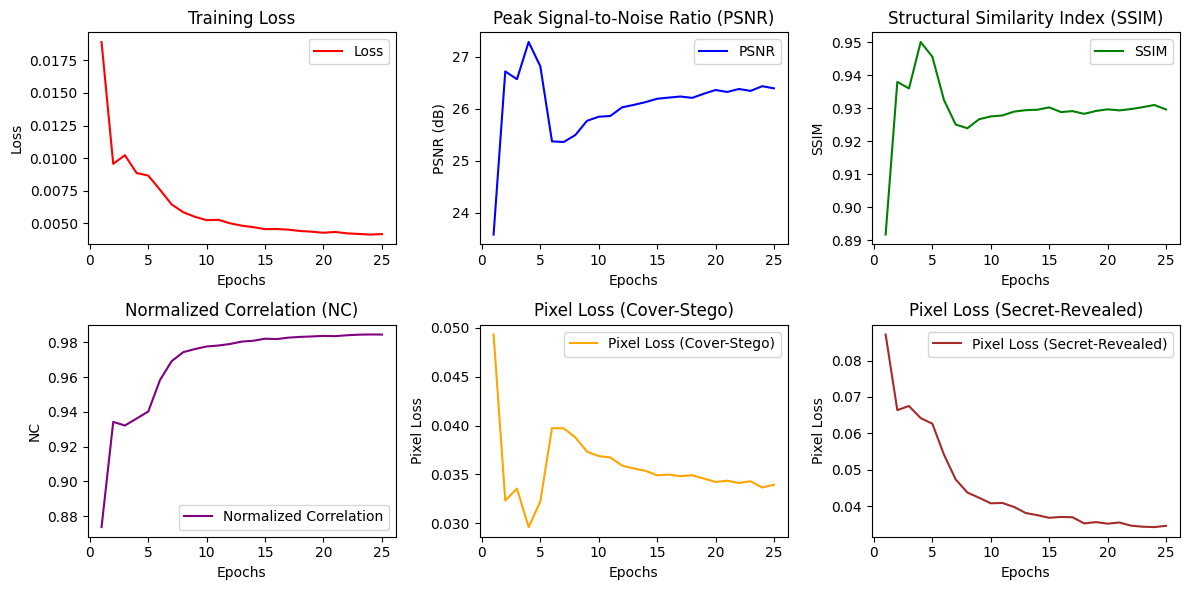


Final Evaluation Metrics:
Final Loss: 0.0042
Final PSNR: 26.3937 dB
Final SSIM: 0.9297
Final Normalized Correlation (NC): 0.9845
Final Pixel Loss (Cover-Stego): 0.0339
Final Pixel Loss (Secret-Revealed): 0.0345



In [ ]:
plot_metrics(metrics)

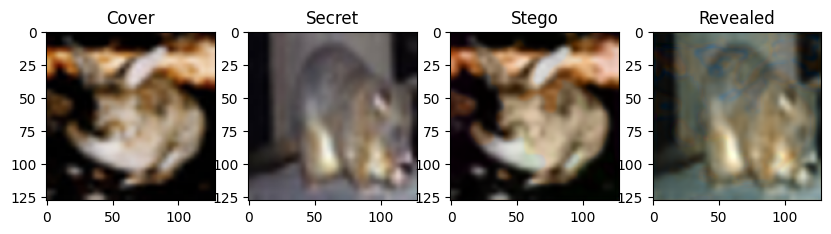

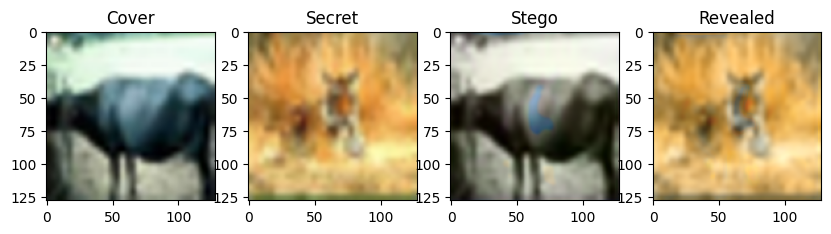

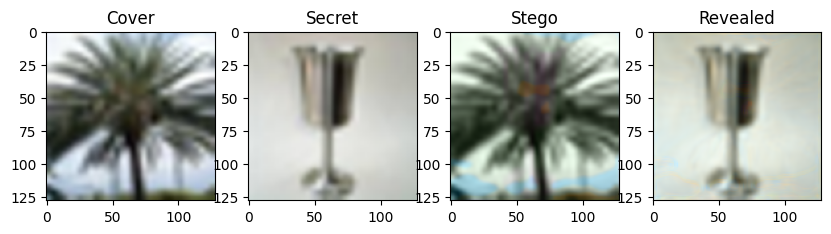

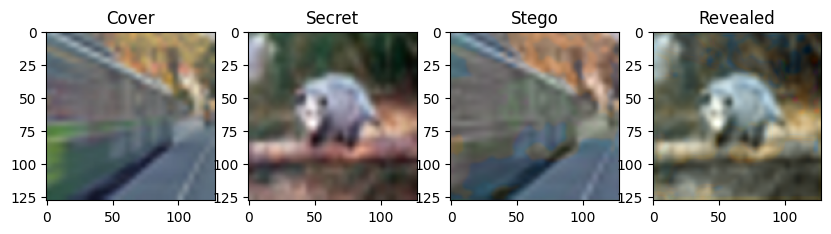

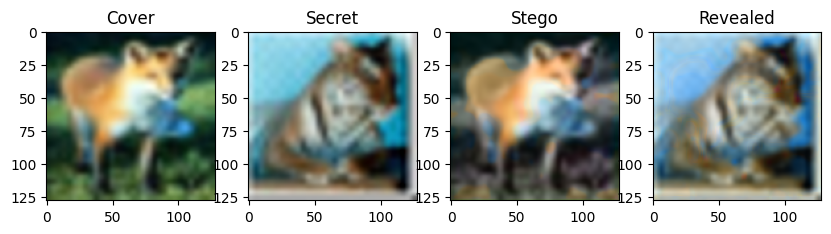

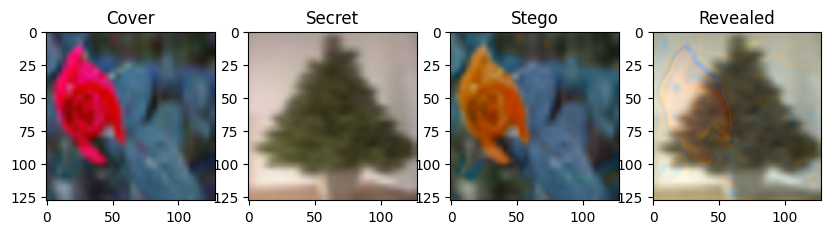

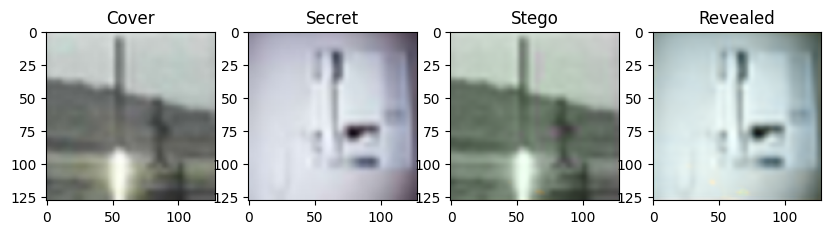

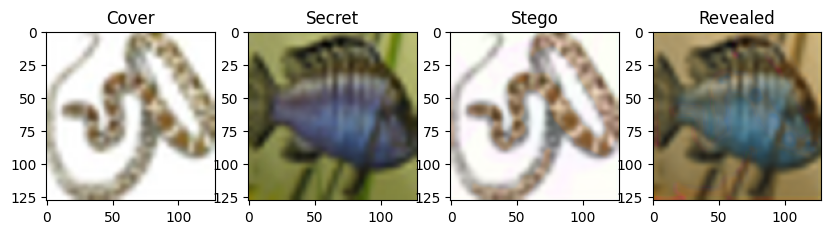

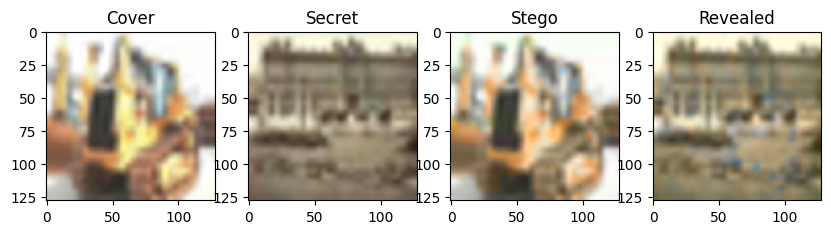

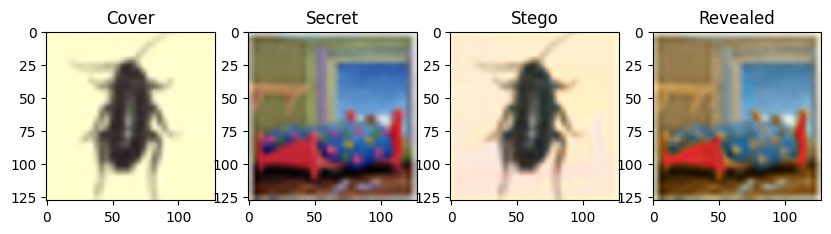

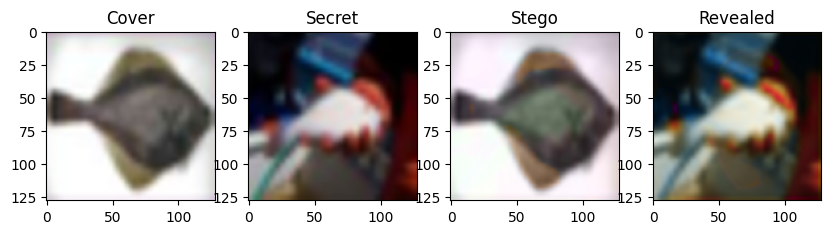

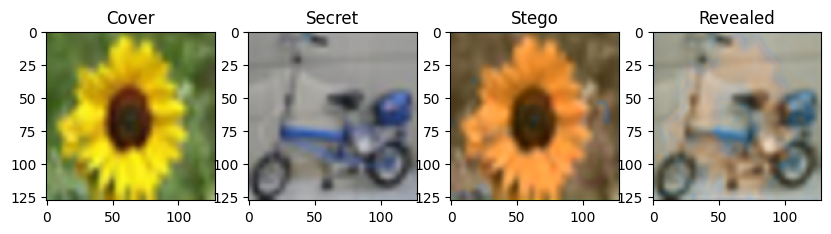

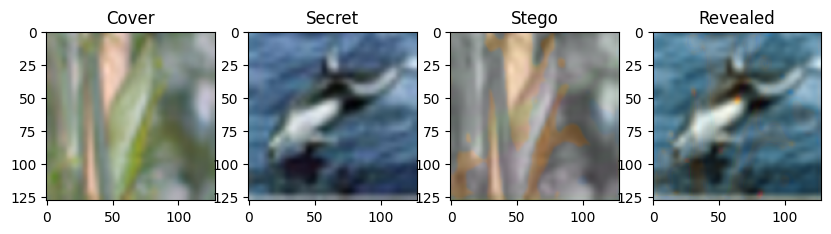

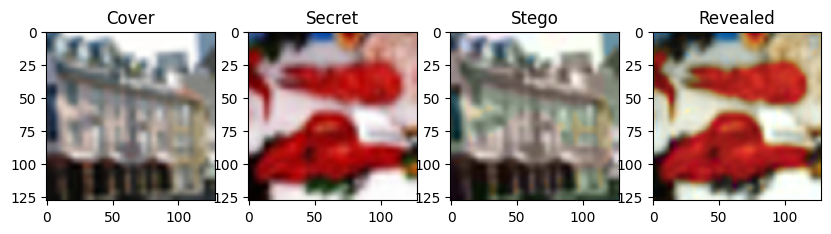

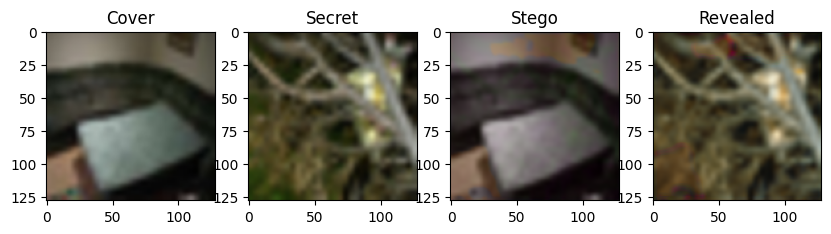


Test Results: Loss: 0.0044, PSNR: 26.4854, SSIM: 0.9319, NC: 0.9841, Pixel Loss (Cover-Stego): 0.0335, Pixel Loss (Secret-Revealed): 0.0389



In [ ]:
metrics = test(prep_net=prep_net,
               hide_net=hide_net,
               reveal_net=reveal_net,
               dataloader=test_loader,
               loss_fn = loss_function,
               beta = 0.75,
               visualize = True,
               device=device)

In [ ]:
torch.save(prep_net.state_dict(), "prep_net.pth")
torch.save(hide_net.state_dict(), "hide_net.pth")
torch.save(reveal_net.state_dict(), "reveal_net.pth")

In [ ]:
import google.colab.files
google.colab.files.download("prep_net.pth")
google.colab.files.download("hide_net.pth")
google.colab.files.download("reveal_net.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>